# GPN-MSA Testing with Datasets

## Setup environment 

In [ ]:
# only need once for GPN-MSA use
# !pip install git+https://github.com/songlab-cal/gpn.git

In [ ]:
# !ldconfig /usr/lib64-nvidia

In [1]:
from gpn.data import GenomeMSA, Tokenizer
import gpn.model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
from transformers import AutoModel, AutoModelForMaskedLM

/cm/shared/apps/spack/0.17.3/cpu/b/opt/spack/linux-rocky8-zen/gcc-8.5.0/anaconda3-2021.05-q4munrgvh7qp4o7r3nzcdkbuph4z7375/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
from datasets import load_dataset, disable_caching
from gpn.data import load_dataset_from_file_or_dir

In [3]:
dataset_prefix = "/expanse/lustre/projects/nji102/sgriesmer/gpn/Datasets/"

In [4]:
input_file =  dataset_prefix + "test.parquet"
dataset = load_dataset_from_file_or_dir(input_file, split="test", is_file=True)

## Create datasets

### Create Pathogenic dataset (only needed once)

In [5]:
dataset_pathogenic = dataset.filter(lambda v: v["source"]=="ClinVar" or (v["label"]=="Common" and "missense" in v["consequence"]))
dataset_pathogenic.shape

Filter:   0%|          | 0/9761267 [00:00<?, ? examples/s]

(39652, 21)

### Create Cancer dataset (only needed once)

In [6]:
dataset_cancer = dataset.filter(lambda v: v["source"]=="COSMIC" or (v["label"]=="Common" and "missense" in v["consequence"]))
dataset_cancer.shape

Filter:   0%|          | 0/9761267 [00:00<?, ? examples/s]

(17587, 21)

### Create Regulatory dataset (only needed once)

In [7]:
cs = ["5_prime_UTR", "upstream_gene", "intergenic", "3_prime_UTR", "non_coding_transcript_exon"]
dataset_regulatory = dataset.filter(lambda v: v["source"]=="OMIM" or (v["label"]=="Common" and "missense" not in v["consequence"] and any([c in v["consequence"] for c in cs])))
dataset_regulatory.shape

Filter:   0%|          | 0/9761267 [00:00<?, ? examples/s]

(2321473, 21)

## Save datasets as parquet files

In [ ]:
dataset_pathogenic_filename = dataset_prefix + "pathogenic.parquet"
dataset_pathogenic.to_parquet(dataset_pathogenic_filename)

In [8]:
dataset_cancer_filename = dataset_prefix + "cancer.parquet"
dataset_cancer.to_parquet(dataset_cancer_filename)

Creating parquet from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

4437401

In [9]:
dataset_regulatory_filename = dataset_prefix + "regulatory.parquet"
dataset_regulatory.to_parquet(dataset_regulatory_filename)

Creating parquet from Arrow format:   0%|          | 0/2322 [00:00<?, ?ba/s]

462555619

# Test and Score with GPN-MSA

## Load Dataset to be Scored (if previously created)

In [10]:
dataset_pathogenic_filename = dataset_prefix + "pathogenic.parquet"
dataset_pathogenic = load_dataset_from_file_or_dir(dataset_pathogenic_filename, split="test", is_file=True)
dataset_pathogenic.shape

(39652, 21)

## Load MSA data

In [11]:
msa_path = "zip:///::https://huggingface.co/datasets/songlab/multiz100way/resolve/main/89.zarr.zip"
genome_msa = GenomeMSA(msa_path)  # can take a minute or two

Loading MSA...
Loading MSA... Done


## Load inference model

In [12]:
from gpn.msa.vep import VEPInference

model_path = "songlab/gpn-msa-sapiens"
window_size = 128
vep_inf = VEPInference(model_path, genome_msa, window_size, disable_aux_features=False)

## Subset Dataset to be Scored

In [40]:
set_start = 30000
set_end = 39652
dataset_pathogenic_set = dataset_pathogenic.select(range(set_start, set_end))
df_pathogenic_set = pd.DataFrame(dataset_pathogenic_set)
df_pathogenic_set

,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,total_samples,freq,OMIM,Gene,PMID,AC,AN,AF,MAF,MAC
0,17,31338139,G,C,Pathogenic,ClinVar,missense_variant,933505,"criteria_provided,_single_submitter",None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
1,17,31340596,T,C,Pathogenic,ClinVar,missense_variant,1070418,"criteria_provided,_single_submitter",None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
2,17,31349177,T,C,Pathogenic,ClinVar,missense_variant,1075890,"criteria_provided,_single_submitter",None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
3,17,31349249,C,T,Pathogenic,ClinVar,missense_variant,2121325,"criteria_provided,_single_submitter",None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
4,17,31488367,G,T,Common,gnomAD,"5_prime_UTR_variant,intron_variant,intron_vari...",None,None,None,...,None,None,None,None,None,55889.0,151506.0,0.36889,0.36889,55889.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9647,Y,2787412,C,T,Pathogenic,ClinVar,missense_variant,9747,no_assertion_criteria_provided,None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
9648,Y,2787426,C,G,Pathogenic,ClinVar,missense_variant,9739,"criteria_provided,_single_submitter",None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
9649,Y,2787515,C,A,Pathogenic,ClinVar,missense_variant,492908,no_assertion_criteria_provided,None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN
9650,Y,2787551,C,T,Pathogenic,ClinVar,missense_variant,9754,no_assertion_criteria_provided,None,...,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN


## Tokenize Dataset

In [41]:
dataset_pathogenic_set.set_transform(vep_inf.tokenize_function)

## Set Arguments for Testing

In [42]:
from transformers import Trainer, TrainingArguments

output_dir = "/expanse/lustre/projects/nji102/sgriesmer/gpn/output"

batch_size = 100
training_args = TrainingArguments(
  output_dir=output_dir,
  per_device_eval_batch_size=batch_size,
  dataloader_num_workers=0,
  remove_unused_columns=False,
#  torch_compile=True,
#  fp16=True,
)

In [43]:
trainer = Trainer(
    model=vep_inf.model,
    args=training_args
)

## Test and Score Dataset Subset

In [44]:
# for debugging purposes
!TORCH_LOGS="+dynamo"
!TORCHDYNAMO_VERBOSE=1

In [45]:
pred=trainer.predict(test_dataset=dataset_pathogenic_set).predictions

## Add Score to Dataframe

In [46]:
gpn_score = vep_inf.postprocess(pred)
df_pathogenic_set["gpn_score"] = gpn_score
df_pathogenic_set.head()

,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,freq,OMIM,Gene,PMID,AC,AN,AF,MAF,MAC,gpn_score
0,17,31338139,G,C,Pathogenic,ClinVar,missense_variant,933505,"criteria_provided,_single_submitter",None,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,-12.350409
1,17,31340596,T,C,Pathogenic,ClinVar,missense_variant,1070418,"criteria_provided,_single_submitter",None,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,-12.276096
2,17,31349177,T,C,Pathogenic,ClinVar,missense_variant,1075890,"criteria_provided,_single_submitter",None,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,-11.199671
3,17,31349249,C,T,Pathogenic,ClinVar,missense_variant,2121325,"criteria_provided,_single_submitter",None,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,-10.639453
4,17,31488367,G,T,Common,gnomAD,"5_prime_UTR_variant,intron_variant,intron_vari...",None,None,None,...,None,None,None,None,55889.0,151506.0,0.36889,0.36889,55889.0,-1.922046


## Plot shows differentiation between Common and Pathogenic mutations

<AxesSubplot:xlabel='gpn_score', ylabel='Count'>

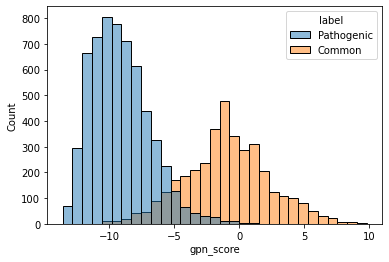

In [47]:
sns.histplot(data=df_pathogenic_set, x="gpn_score", hue="label")

## Save dataframe as CSV

In [48]:
output_file = output_dir + "/pathogenic_set" + "_" + str(set_start) + "_" + str(set_end) + ".csv"
df_pathogenic_set.to_csv(output_file, index=False, sep=',')